In [1]:
import numpy as np  
import pandas as pd #pd attributes .index, columns, axes, dtypes, size, shape, ndim, empty, values; T for transpose

import json
import os

import sklearn

from keras import losses, models, optimizers, activations, layers
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
import keras.utils


from scipy import signal
import scipy
import librosa
import librosa.display  as librosa_display

import matplotlib.pyplot as plt
import IPython.display  as ipd

import warnings
warnings.filterwarnings("ignore",'.*PySoundFile failed. Trying audioread instead*.' )

In [2]:
## Kaggle: sign in and turn on internet access from settings (right panel)
#! git clone https://github.com/tyiannak/pyAudioAnalysis.git
#! pip install pyAudioAnalysis 
#import pyAudioAnalysis
#from pyAudioAnalysis import audioSegmentation as aS
! pip install auditok
import auditok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.6 MB/s eta 0:00:00


In [3]:
def getaudio (filename):
    try : 
        tmp , sr = librosa.load(directory_path + filename + '.webm')
    except:
        tmp , sr = librosa.load(directory_path + filename + '.ogg')
    
    return tmp

#consult hysterisis  https://c4science.ch/R10770:1517d05b5315675c3f14bb705e9e56d5576563a5#change-boxYFHaB5gxM

def getlabel (filename):

    file = open(directory_path + filename + '.json')
    data = json.load(file)
    try: 
        tmp = data['status']
    except:
        tmp = 'not found'
        
    return tmp



'''
def getsegments (filename):
    f_filename  = (directory_path + filename + '.webm')
    
    [flagsInd] = aS.mid_term_file_classification(f_filename, "data/models/svm_rbf_sm", "svm", True) #https://github.com/tyiannak/pyAudioAnalysis/blob/71c67d921aa0d059b57e95103d08aaf35c177efa/pytests/test_segmentation.py
    
    print(flagsInd)
    
    sound = audio(f_filename)
    cough = []
    
    for i in flagsInd:
        cough.append(sound[i:i+1])
    
    return cough
    '''
    
    
def auditok_split (filename):
    
    audio_regions = auditok.split(directory_path + filename + '.webm')

    sound = audio(filename)
    cough = []
    
    for i in flagsInd:
        cough.append(sound[i:i+1])
    
    return cough

In [4]:
directory_path = '/kaggle/input/covid19-cough-audio-classification/'
metadata_file = "metadata_compiled.csv"

metadata = pd.read_csv(directory_path + metadata_file, sep=",")
#print(metadata.columns, metadata.shape)

metadata = metadata.iloc[: , :-40]
metadata = metadata.loc[~((metadata['status'].isnull() ) | (metadata['age'].isnull()) ),]
print(metadata.shape, 'columns' , metadata.columns, '/n',metadata.dtypes)

'TESTING THE FUNCTIONS STARTS HERE'

metadata_proto = metadata[:14]



for file_name_i in metadata_proto['uuid']:
    print(getlabel(file_name_i))

    

(15218, 11) columns Index(['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
       'age', 'gender', 'respiratory_condition', 'fever_muscle_pain',
       'status'],
      dtype='object') /n uuid                      object
datetime                  object
cough_detected           float64
SNR                      float64
latitude                 float64
longitude                float64
age                      float64
gender                    object
respiratory_condition     object
fever_muscle_pain         object
status                    object
dtype: object
healthy
healthy
healthy
healthy
healthy
healthy
healthy
symptomatic
healthy
healthy
healthy
symptomatic
healthy
healthy


In [5]:
train_ft = ['uuid']

y_label = ['status']

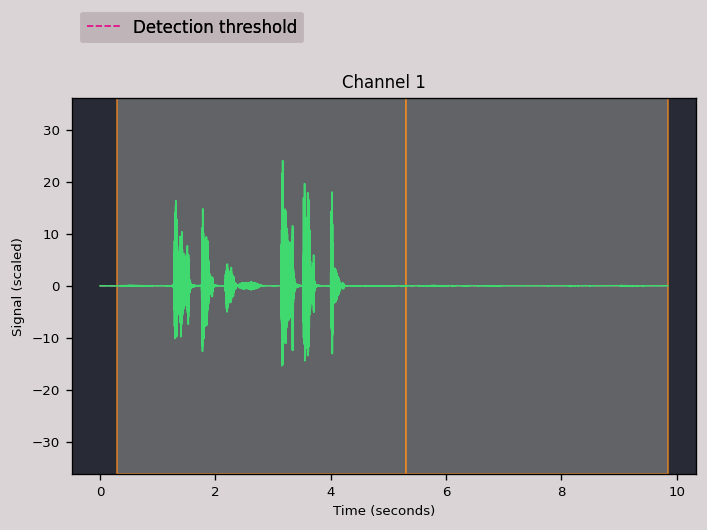

[AudioRegion(duration=5.000, sampling_rate=48000, sample_width=4, channels=1), AudioRegion(duration=4.540, sampling_rate=48000, sample_width=4, channels=1)]
[AudioRegion(duration=5.000, sampling_rate=48000, sample_width=4, channels=1), AudioRegion(duration=4.540, sampling_rate=48000, sample_width=4, channels=1)]


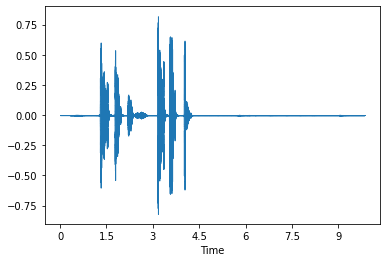

In [6]:
directory_path = '../input/covid19-cough-audio-classification/'
audio_path     = directory_path + file_name_i + '.webm'
    
audio_regions = auditok.load(audio_path).split_and_plot(sr=41000)

sound = getaudio(file_name_i)

print(audio_regions)

print(list(audio_regions))


librosa.display.waveshow(sound)

ipd.Audio(audio_path)

In [7]:
detections = ((reg.meta.start, reg.meta.end) for reg in list(audio_regions))
detections


for i, r in enumerate(audio_regions):

    filename = r.save(file_name_i+"_{meta.start:.3f}-{meta.end:.3f}.webm")
    print("region saved as: {}".format(filename))

region saved as: 0044cb7b-448c-44e5-8302-ad8bd106fe3e_0.300-5.300.webm
region saved as: 0044cb7b-448c-44e5-8302-ad8bd106fe3e_5.300-9.840.webm


In [8]:



#Use old segmentation
def segment_cough(x,fs = 48000, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    '''segmenting  file > individual coughs  : hysteresis comparator on the signal power

    INPUTS
     *x   np.array : cough signal
     *fs  float    : sampling frequency Hz
     *cough_padding    (float) : number of seconds added  to the beginning and end of  each detected cough to make sure  coughs are not cut short
     *min_cough_length (float) : length of the minimum possible segment  that can be considered a cough
     *th_l_multiplier  (float) : multiplier of the RMS energy used as a low  threshold of the hysteresis comparator
     *th_h_multiplier  (float) : multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    OUTPU
     coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough    '''
    

    #Hysteresis thresholds Definitions:
    RMS = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * RMS
    seg_th_h = th_h_multiplier * RMS

    #Segmentation
    
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            # counting and adding cough samples
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])

            # cough end
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            # reset counter for number of sample tolerance 
            else:
                below_th_counter = 0
        else:
            # start cough
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments

In [9]:
x, fs = librosa.load(audio_path, sr=48000)
cough_segments, cough_mask = segment_cough(x, fs, cough_padding=0)

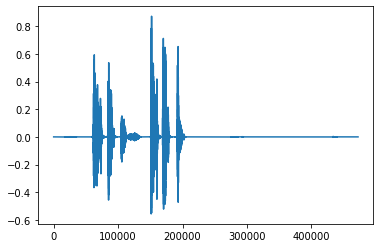

In [10]:
#plt.plot(cough_segments)
len(cough_segments)
plt.plot(x)
